In [1]:
import Load_Downsize_SaveAsH5 as cvt

import numpy as np
import h5py
import pandas as pd
import tensorflow as tf
from keras.losses import categorical_crossentropy
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import roc_curve, auc

Using TensorFlow backend.


### partial data with Top as target

In [2]:
filePath = './data/'
features = ['j_index','j1_phirel','j1_etarel','j1_phirot','j1_etarot','j1_deltaR','j1_pdgid','j1_pt','j1_ptrel','j1_erel'] 
labels = ['j_g','j_q','j_w','j_z','j_t']
# ratio=[.25,.25,.25,.25,1]
size=19000
seed=42
N_par=20                       # number of constituents in a jet

In [3]:
cvt.LoadTransSave(filePath,features, labels,size=size,seed=seed)

100%|███████████████████████████████████████████████████████████████████████████| 95000/95000 [10:43<00:00, 147.53it/s]


### prepare data

In [3]:
cols = dict(zip(features+['constituents_index'], [i for i in range(len(features)+1)]))

features_list = ['j1_ptrel','j1_etarot','j1_phirot','j1_phirel','j1_etarel','j1_erel','j1_deltaR','j1_pdgid']

def h5_to_data(h5path):
    Data = {'mask':[], 'points':[], 'features':[],'label':[]}
    f = h5py.File(h5path,'r')
    raw_data = np.array([f[col][()] for col in cols])
    label_arr = f['label'][()]
    raw_data = raw_data.transpose((1,0))
    mask, features, points = np.zeros((N_par,1)), np.zeros((N_par,len(features_list))), np.zeros((N_par,2)) # prepare constituents list
    for i in range(len(raw_data)):
        cIndex = int(raw_data[i][cols['constituents_index']])
        if cIndex >= N_par:                                               # skip when excess N_par particles
            continue
        
        mask[cIndex] = [1]                                             # no mask for now
        points[cIndex] = np.array([raw_data[i][cols['j1_etarel']],raw_data[i][cols['j1_phirel']]])
        features[cIndex] = np.array([raw_data[i][cols[feat]] for feat in features_list])
                
        if i < len(raw_data)-1:
            if raw_data[i][cols['j_index']] != raw_data[i+1][cols['j_index']] : # save the jet before switch to another
                Data['mask'].append(mask)
                Data['points'].append(points)
                Data['features'].append(features)
                Data['label'].append(label_arr[i])
                mask, features, points = np.zeros((N_par,1)), np.zeros((N_par,len(features_list))), np.zeros((N_par,2))  
    f.close()
    y = Data.pop('label')
    return Data, y

def merging(gg,qq):
    total={}
    total['mask']=gg["mask"]+qq["mask"]
    total['features']=gg["features"]+qq["features"]
    total['points']=gg['points']+qq['points']
    return total

def separatedata(Data,y,rateval,ratetest,seed):
    features_train, features_test, features_val={},{},{}
    from sklearn.model_selection import train_test_split
    mask = Data["mask"]
    features = Data["features"]
    points = Data["points"]
    X_ind = [i for i in range(len(y))]
    X_train, X_ind, y_train, y_ind = train_test_split(X_ind, y, test_size=rateval+ratetest, random_state=seed)
    X_val, X_test, y_val, y_test = train_test_split(X_ind, y_ind, test_size=(rateval/(rateval+ratetest)), random_state=seed)

    features_train['mask']=np.array([mask[i] for i in X_train])
    features_train['features']=np.array([features[i] for i in X_train])
    features_train['points']=np.array([points[i] for i in X_train])

    features_test['mask']=np.array([mask[i] for i in X_test])
    features_test['features']=np.array([features[i] for i in X_test])
    features_test['points']=np.array([points[i] for i in X_test])

    features_val['mask']=np.array([mask[i] for i in X_val])
    features_val['features']=np.array([features[i] for i in X_val])
    features_val['points']=np.array([points[i] for i in X_val])

    return features_train, features_val, features_test,np.array(y_train), np.array(y_val), np.array(y_test)

In [4]:
h5Path = "data/data_19000jets_5labels.h5"
Data,y = h5_to_data(h5Path)
print("check shape: ",Data['mask'][0].shape,Data['points'][0].shape,Data['features'][0].shape)

check shape:  (20, 1) (20, 2) (20, 8)


In [5]:
X_train, X_val, X_test, y_train, y_val, y_test = separatedata(Data,y,0.25,0.25,seed)

In [6]:
import sys
sys.path.insert(0,'tf-keras')
from tf_keras_model import get_particle_net_lite, get_particle_net

In [7]:
input_shapes={'points': X_train['points'][0].shape, 'features': X_train['features'][0].shape, 'mask': X_train['mask'][0].shape}
num_classes = 5
model = get_particle_net_lite(num_classes, input_shapes)

In [8]:
batch_size = 1024
epochs = 100

In [9]:
opt = tf.keras.optimizers.Adam(lr=1e-4)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "ParticleNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
mask (InputLayer)               [(None, 20, 1)]      0                                            
__________________________________________________________________________________________________
tf_op_layer_NotEqual (TensorFlo [(None, 20, 1)]      0           mask[0][0]                       
__________________________________________________________________________________________________
tf_op_layer_Cast (TensorFlowOpL [(None, 20, 1)]      0           tf_op_layer_NotEqual[0][0]       
__________________________________________________________________________________________________
tf_op_layer_Equal (TensorFlowOp [(None, 20, 1)]      0           tf_op_layer_Cast[0][0]           
________________________________________________________________________________________

In [10]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=2),
    tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5'),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]

In [11]:
history = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs, 
          validation_data=(X_val, y_val),
          shuffle=True,
        callbacks = None)

Train on 947437 samples, validate on 473718 samples
Epoch 1/100
947437/947437 [==============================] - 56s 60us/sample - loss: 1.4927 - accuracy: 0.3505 - val_loss: 1.4310 - val_accuracy: 0.3895
Epoch 2/100
947437/947437 [==============================] - 52s 55us/sample - loss: 1.4033 - accuracy: 0.4001 - val_loss: 1.3769 - val_accuracy: 0.4133
Epoch 3/100
947437/947437 [==============================] - 52s 55us/sample - loss: 1.3740 - accuracy: 0.4133 - val_loss: 1.3592 - val_accuracy: 0.4212
Epoch 4/100
947437/947437 [==============================] - 52s 55us/sample - loss: 1.3614 - accuracy: 0.4191 - val_loss: 1.3510 - val_accuracy: 0.4256
Epoch 5/100
947437/947437 [==============================] - 52s 55us/sample - loss: 1.3546 - accuracy: 0.4228 - val_loss: 1.3449 - val_accuracy: 0.4294
Epoch 6/100
947437/947437 [==============================] - 53s 56us/sample - loss: 1.3498 - accuracy: 0.4243 - val_loss: 1.3418 - val_accuracy: 0.4300
Epoch 7/100
947437/947437 [===

In [ ]:
model.evaluate(X_test,  y_test, verbose=2)

In [25]:
labels = ['j_g','j_q','j_w','j_z','j_t']

In [22]:
def makeRoc(features_val, labels_val, labels, model, outputSuffix=''):
    predict_test = model.predict(features_val)
    df = pd.DataFrame()
    fpr = {}
    tpr = {}
    auc1 = {}
    plt.figure()       
    for i, label in enumerate(labels):
        df[label] = labels_val[:,i]
        df[label + '_pred'] = predict_test[:,i]
        fpr[label], tpr[label], threshold = roc_curve(df[label],df[label+'_pred'])
        auc1[label] = auc(fpr[label], tpr[label])
        plt.plot(tpr[label],fpr[label],label='%s tagger, AUC = %.1f%%'%(label.replace('j_',''),auc1[label]*100.))
    plt.semilogy()
    plt.xlabel("Signal Efficiency")
    plt.ylabel("Background Efficiency")
    plt.ylim(0.001,1)
    plt.grid(True)
    plt.legend(loc='upper left')
    plt.title('%s_ROC_Curve'%(outputSuffix))
#     plt.savefig('%s_ROC.png'%(outputSuffix))
    return predict_test

array([[0.26824868, 0.10897232, 0.29899868, 0.2252985 , 0.09848185],
       [0.26931006, 0.07196701, 0.04870947, 0.07709441, 0.53291905],
       [0.15750316, 0.06402493, 0.19441417, 0.27947664, 0.3045811 ],
       ...,
       [0.42511582, 0.28059664, 0.0889871 , 0.07863872, 0.1266617 ],
       [0.40212622, 0.41794902, 0.08917151, 0.06825019, 0.02250304],
       [0.2638256 , 0.07128651, 0.07461966, 0.12654236, 0.46372586]],
      dtype=float32)

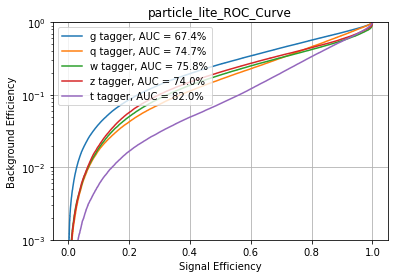

In [24]:
makeRoc(X_test, y_test, labels, model, outputSuffix='particle_lite')

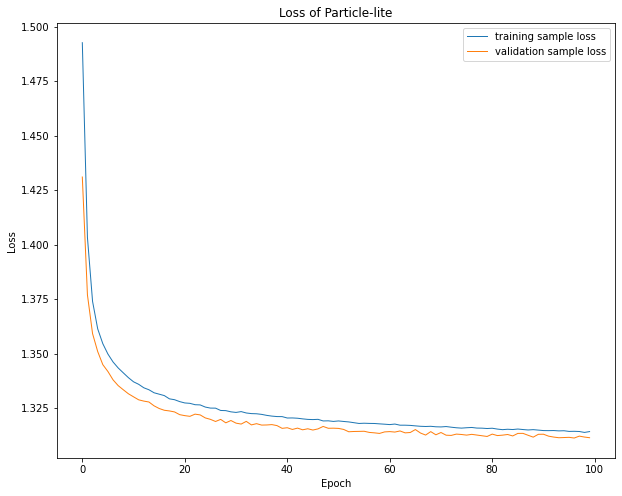

In [18]:
plt.figure(figsize=(10,8))
plt.plot(history.history['loss'], linewidth=1)
plt.plot(history.history['val_loss'], linewidth=1)
plt.title('Loss of Particle-lite')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training sample loss','validation sample loss'])
plt.show()
plt.close()